In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import mplleaflet
import mpl_toolkits
import folium
import branca.colormap as cm
import pylab as pl
import os
# from folium.plugins import MarkerCluster

home_dir = os.environ['HOME']

In [7]:
# Read the shapefile you can download from this repo https://github.com/gweissman86/three_digit_zips
us_3zip = gpd.read_file(home_dir + "/GitHub/three_digit_zips/three_dig_zips/three_dig_zips.shp")
us_3zip.head()

,3dig_zip,geometry
0,032,"POLYGON ((-71.66777 43.15253, -71.6349 43.0335..."
1,033,"POLYGON ((-71.62792 43.16028, -71.60296 43.165..."
2,034,"POLYGON ((-71.94428 42.78841, -71.92902 42.712..."
3,035,"POLYGON ((-71.53762 44.1975, -71.58151 44.1120..."
4,281,"MULTIPOLYGON (((-79.96892 34.80745, -80.79754 ..."


<Axes: >

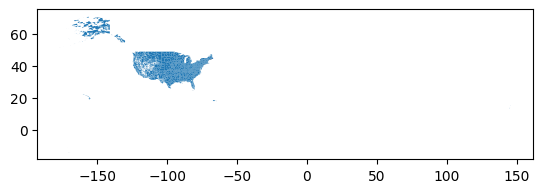

In [3]:
us_3zip.plot()

In [ ]:
# reduce axis to only see CONUS
x1, y1, x2, y2 = (-130, 20, -50, 50)
us_3zip_conus = us_3zip[
    (us_3zip.centroid.x > x1)
    & (us_3zip.centroid.y > y1)
    & (us_3zip.centroid.x < x2)
    & (us_3zip.centroid.y < y2)
]

<Axes: >

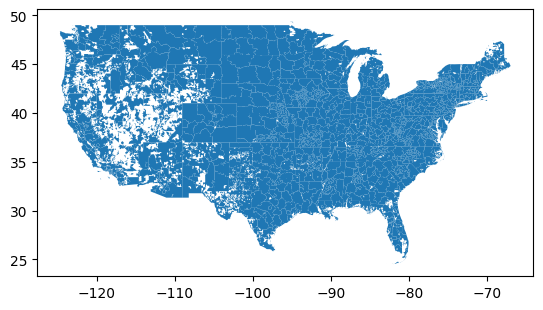

In [5]:
us_3zip_conus.plot()

In [ ]:
# get centroids and use at lat long
us_3zip_conus["lat"], us_3zip_conus["long"] = (
    us_3zip_conus.centroid.y,
    us_3zip_conus.centroid.x,
)
us_3zip_conus = us_3zip_conus.drop(columns=["geometry"])
us_3zip_conus.head()

In [7]:
us_3zip_conus["3dig_zip"]

0      032
1      033
2      034
3      035
4      281
      ... 
891    156
892    036
893    037
894    038
895    039
Name: 3dig_zip, Length: 884, dtype: object

In [ ]:
# make a fake dataset
index = pd.MultiIndex.from_product(
    [us_3zip_conus["3dig_zip"], us_3zip_conus["3dig_zip"]], names=["org", "dest"]
)

fake_data = pd.DataFrame(index=index).reset_index()
fake_data = fake_data[fake_data["org"] != fake_data["dest"]]

# add fake vol per week
fake_data["vol_per_week"] = np.random.randint(1, 11, size=len(fake_data))
fake_data.head()


,org,dest,vol_per_week
1,032,033,7
2,032,034,9
3,032,035,4
4,032,281,6
5,032,282,4


In [9]:
# remove cartesian product while summing columns
fake_data[["org", "dest"]] = pd.DataFrame(
    np.sort(fake_data[["org", "dest"]].values, axis=1)
)
fake_data = fake_data.groupby(["org", "dest"]).vol_per_week.sum().reset_index()
fake_data.shape

(390286, 3)

In [10]:
# Lets sample this to make it more realistic
df_sample = fake_data.sample(frac=0.005, random_state=42)
df_sample.shape

(1951, 3)

In [11]:
# make our network X from fake data
# load the nodes and edges
G = nx.from_pandas_edgelist(df_sample, "org", "dest", "vol_per_week")

# get edge weights
widths = nx.get_edge_attributes(G, "vol_per_week")

# get degree
# Calculate node degrees
node_degrees = dict(G.degree())

# Set node size based on degree
node_sizes = [node_degrees[node] * 5 for node in G.nodes()]

pos = us_3zip_conus[["3dig_zip", "long", "lat"]].set_index("3dig_zip").T.to_dict("list")


In [12]:
# in mac you need to export geo library before install
# export GEOS_DIR=/opt/homebrew/Cellar/geos/3.13.0
from mpl_toolkits.basemap import Basemap as Basemap


In [13]:
plt.figure(figsize=(10, 10))

basemap = Basemap(
    projection="merc",
    llcrnrlon=-125,
    urcrnrlon=-70,
    llcrnrlat=25,
    urcrnrlat=50,
    lat_ts=0,
    resolution="l",
    suppress_ticks=True,
)

<Figure size 1000x1000 with 0 Axes>

In [14]:
basemap_x, basemap_y = basemap(
    us_3zip_conus["long"].values, us_3zip_conus["lat"].values
)

pos = {}
for i, zip in enumerate(us_3zip_conus["3dig_zip"]):
    pos[zip] = (basemap_x[i], basemap_y[i])

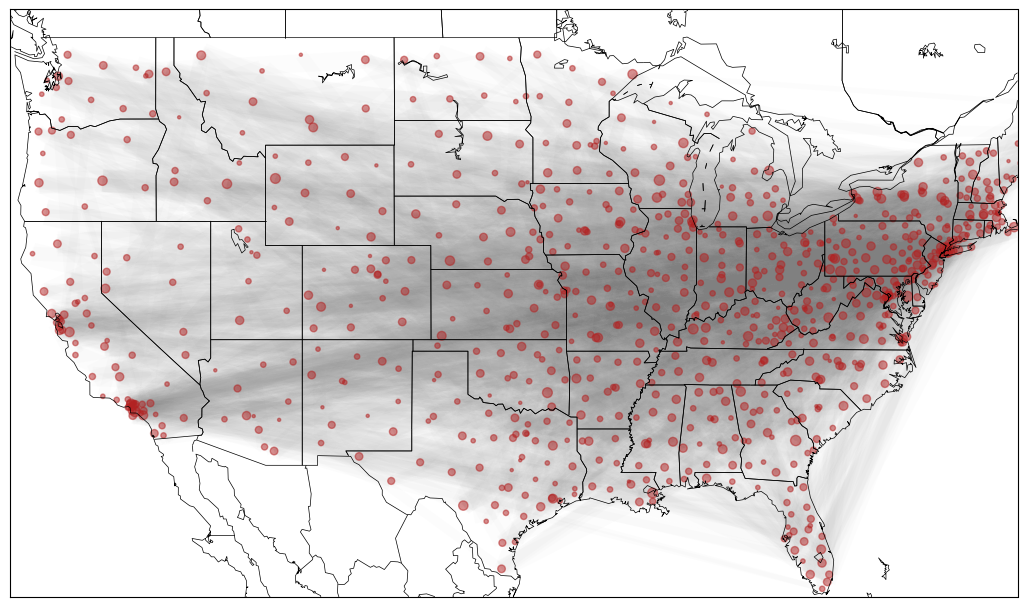

In [15]:
ax = plt.figure(figsize=(13, 13))


nx.draw_networkx_nodes(
    G=G,
    pos=pos,
    nodelist=G.nodes(),
    node_color="firebrick",
    alpha=0.5,
    node_size=node_sizes,
)

# based on edge width
nx.draw_networkx_edges(
    G=G,
    pos=pos,
    edge_color="grey",
    alpha=0.02,
    width=list(widths.values()),
    arrows=False,
)

basemap.drawcoastlines(linewidth=0.5)
basemap.drawstates(linewidth=0.5)
basemap.drawcountries(linewidth=0.5)


/var/folders/p_/rsfcf63x5hb0lb9h219g4nl40000gn/T/ipykernel_34202/1219823794.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


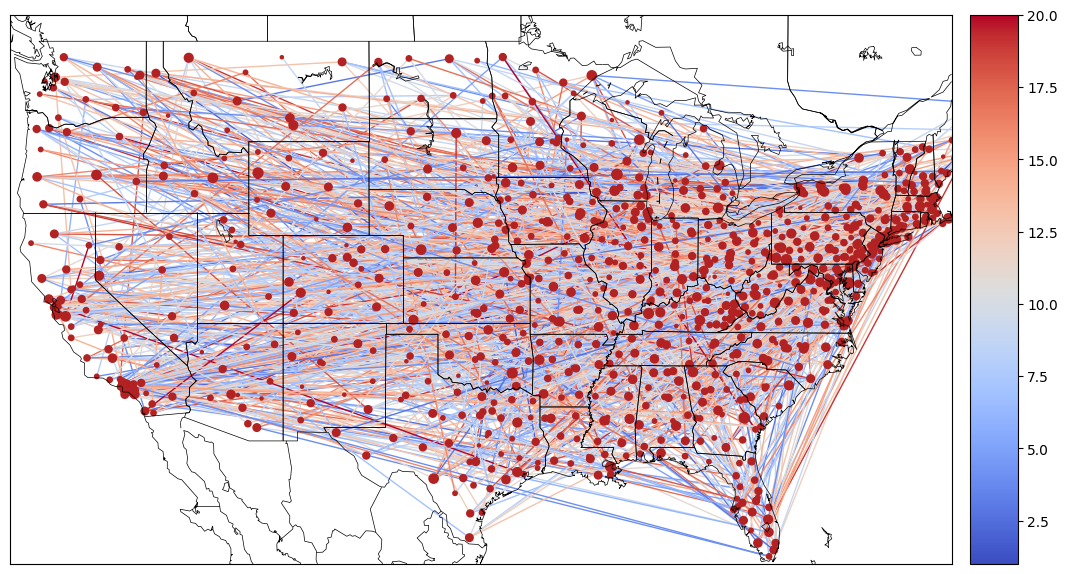

In [16]:
ax = plt.figure(figsize=(13, 13))
cmap = plt.cm.get_cmap("coolwarm")


edges = nx.draw_networkx_edges(
    G=G,
    pos=pos,
    edge_color=list(widths.values()),
    width=1,
    edge_cmap=cmap,
    arrows=False,
)

nodes = nx.draw_networkx_nodes(
    G=G, pos=pos, nodelist=G.nodes(), node_color="firebrick", node_size=node_sizes
)

# color based off of weight
basemap.drawcoastlines(linewidth=0.5)
basemap.drawstates(linewidth=0.5)
basemap.drawcountries(linewidth=0.5)

basemap.colorbar(edges)

## Let's make an interactive map in folium

In [17]:
# Need to update positions with real lat/longs instead of basemap conversion
pos2 = {}
pos2 = (
    us_3zip_conus[["3dig_zip", "lat", "long"]].set_index("3dig_zip").T.to_dict("list")
)


In [18]:
step = cm.LinearColormap(["green", "yellow", "red"], vmin=1, vmax=20)
step

In [19]:
from folium.plugins import FloatImage

# Create a Folium map centered on the first node's coordinates
m = folium.Map(location=[us_3zip_conus.lat[0], us_3zip_conus.long[0]], zoom_start=5)
# create edge colormap
step = cm.LinearColormap(
    ["blue", "yellow", "red"], vmin=min(widths.values()), vmax=max(widths.values())
)


# Add edges to the map
for edge in G.edges():
    edge_size = widths[edge[0], edge[1]]
    folium.PolyLine(
        [pos2[edge[0]], pos2[edge[1]]],
        color=step(edge_size),
        weight=edge_size / 3,
        opacity=0.3,
        popup=f"{edge[0]} to {edge[1]} volume: {edge_size}",
    ).add_to(m)

# Add nodes to the map
for node in G.nodes():
    degree = node_degrees[str(node)]
    folium.CircleMarker(
        location=pos2[node],
        radius=(degree),
        color="black",
        weight=1,
        fill_opacity=0.6,
        opacity=1,
        fill_color="green",
        fill=False,
        popup=f"zip_3: {node} connections: {degree}",
    ).add_to(m)

# add legend to plot
step.caption = "Volume per week"
step.add_to(m)


# Save the map as an HTML file
m.save("network_map.html")

In [ ]:
rfp = pd.read_csv(
    home_dir + "/Downloads/quotes_3dz_volume_2024.csv", header=0
)
actual = pd.read_csv(
    home_dir + "/Downloads/actualloads_3dz_buyvsmarket_2024.csv", header=0
)
actual = actual.rename(
    columns={"Origin 3DZ": "org", "Destination 3DZ": "dest", "total_loads": "vol"}
)
df_actual = actual[["org", "dest", "vol"]]

# drop na
df_actual = df_actual.dropna()

# strip whitespace
df_actual = df_actual.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# remove letters
df_actual = df_actual[~df_actual["org"].astype(str).str.contains("[a-zA-Z]")]
df_actual = df_actual[~df_actual["dest"].astype(str).str.contains("[a-zA-Z]")]

df_actual = df_actual[pd.to_numeric(df_actual["org"], errors="coerce").notnull()]
df_actual = df_actual[pd.to_numeric(df_actual["dest"], errors="coerce").notnull()]

# make sure all three digits sorry for terrible code, time crunch
df_actual["org"] = df_actual.org.astype(str).str.zfill(3)
df_actual["dest"] = df_actual.dest.astype(str).str.zfill(3)

# df_actual['vol'] = pd.to_numeric(df_actual['vol'])
df_actual.head()

In [ ]:
df_actual.shape

In [ ]:
# remove cartesian product
df_actual[["org", "dest"]] = pd.DataFrame(
    np.sort(df_actual[["org", "dest"]].values, axis=1)
)
df_actual = df_actual.groupby(["org", "dest"]).vol.sum().reset_index()
df_actual.shape

In [ ]:
# remove rows without real 3dz
df_actual = df_actual[df_actual["org"].isin(us_3zip_conus["3dig_zip"])]
df_actual = df_actual[df_actual["dest"].isin(us_3zip_conus["3dig_zip"])]

df_actual.shape

In [ ]:
# make our network X from fake data
# load the nodes and edges
G2 = nx.from_pandas_edgelist(df_actual, "org", "dest", "vol")

# get edge weights
widths2 = nx.get_edge_attributes(G2, "vol")

# get degree
# Calculate node degrees
node_degrees2 = dict(G2.degree())

# Set node size based on degree
node_sizes2 = [node_degrees2[node] * 5 for node in G2.nodes()]


In [ ]:
# adjust colormap to follow a better segmentation of what we see in the data
step = cm.LinearColormap(
    colors=["darkblue", "blue", "cyan", "yellow", "orange", "red"],
    index=[0, 25, 200, 500, 1000, 2000],
    vmin=min(widths2.values()),
    vmax=max(widths2.values()),
    tick_labels=[0, 200, 500, 1000, 2000],
)
step

In [ ]:
# Create a Folium map centered on the first node's coordinates
m = folium.Map(location=[us_3zip_conus.lat[0], us_3zip_conus.long[0]], zoom_start=5)

# create edge colormap
# step = cm.LinearColormap(["blue", "yellow", "red"],
#                          vmin=min(widths2.values()),
#                          vmax=500,
#                          tick_labels=[0,250,500])
step = cm.LinearColormap(
    colors=["darkblue", "blue", "cyan", "yellow", "orange", "red"],
    index=[0, 100, 250, 500, 750, 1500],
    vmin=min(widths2.values()),
    tick_labels=[0, 250, 500, 2000],
    vmax=max(widths2.values()),
)


# Add edges to the map
for edge in G2.edges():
    edge_size = widths2[edge[0], edge[1]]
    folium.PolyLine(
        [pos2[edge[0]], pos2[edge[1]]],
        color=step(edge_size),
        weight=edge_size / 150,
        opacity=0.3,
        popup=f"zip3 {edge[0]} to {edge[1]} volume: {edge_size}",
    ).add_to(m)

# Add nodes to the map
for node in G2.nodes():
    degree = node_degrees2[str(node)]
    folium.CircleMarker(
        location=pos2[node],
        radius=(degree) / 35,
        color="black",
        weight=1,
        fill_opacity=0.6,
        opacity=1,
        fill_color="green",
        fill=False,
        popup=f"zip_3: {node} connections: {degree}",
    ).add_to(m)

# add legend to plot
step.caption = "Volume over 2024"
step.add_to(m)

# add fancy (legend) but must be a photo
# FloatImage(home_dir + "/GitHub/Random_Python_Scripts/Graphs/colorbar.png", bottom=0, left=70).add_to(m)


# Save the map as an HTML file
m.save("network_map_actual.html")

In [ ]:
# import leafmap.foliumap as leafmap
# params = {
#     "width": 4.0,
#     "height": 0.3,
#     "vmin": min(widths2.values()),
#     "vmax": max(widths2.values()),
#     "cmap": 'plasma',
#     "label": "Volume per lane (2024)",
#     "orientation": "horizontal",
#     "transparent": False,
# }
# params["transparent"] = True
# leafmap.save_colorbar("colorbar.png", **params)

In [ ]:
def make_Ramp(ramp_colors):
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    # color_ramp = LinearSegmentedColormap.from_list( 'Volume', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    # print([ Color( c1 ).rgb for c1 in ramp_colors ])

    color_ramp = LinearSegmentedColormap.from_list(
        "",
        [
            (0, "darkblue"),
            (0.1, "blue"),
            (0.2, "cyan"),
            (0.3, "yellow"),
            (0.6, "orange"),
            (1, "red"),
        ],
        N=256,
    )
    # plt.figure()
    # plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ],
    #            interpolation='nearest',
    #            origin='lower',
    #         #    cmap= color_ramp,
    #            vmin=min(widths2.values()),
    #            vmax=max(widths2.values()))
    # plt.xticks([150,250,500,1000])
    # plt.yticks([])
    # plt.colorbar()
    return color_ramp


custom_ramp = make_Ramp(["darkblue", "blue", "cyan", "yellow", "orange", "red"])


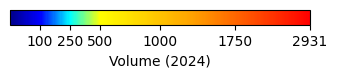

In [ ]:
a = np.array([[0, 1]])
pl.figure(figsize=(15, 3))
img = pl.imshow(a, cmap=custom_ramp)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.2, 0.05])
# x, y = 0, 20
# width = 10
# height = 0.5
# cax = pl.axes([x, y, width, height])
pl.colorbar(orientation="horizontal", cax=cax)
cax.set_xticks([0.1, 0.2, 0.3, 0.5, 0.75, 1])
cax.set_xticklabels(["100", "250", "500", "1000", "1750", str(max(widths2.values()))])
cax.set_xlabel("Volume (2024)")
pl.savefig("colorbar.png", transparent=True, pad_inches=0)


In [ ]:
rfp = pd.read_csv(home_dir + "/Downloads/RFP_Footprint_2024.csv", header=0)
rfp = rfp[["O_TDZ", "D_TDZ", "Sum of Total Lane Count"]]
rfp = rfp.rename(
    columns={"O_TDZ": "org", "D_TDZ": "dest", "Sum of Total Lane Count": "num_bids"}
)


# drop na
df_rfp = rfp.dropna()

# strip whitespace
df_rfp = df_rfp.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# remove letters
df_rfp = df_rfp[~df_rfp["org"].astype(str).str.contains("[a-zA-Z]")]
df_rfp = df_rfp[~df_rfp["dest"].astype(str).str.contains("[a-zA-Z]")]

df_rfp = df_rfp[pd.to_numeric(df_rfp["org"], errors="coerce").notnull()]
df_rfp = df_rfp[pd.to_numeric(df_rfp["dest"], errors="coerce").notnull()]

# make sure all three digits sorry for terrible code, time crunch
df_rfp["org"] = df_rfp.org.astype(str).str.zfill(3)
df_rfp["dest"] = df_rfp.dest.astype(str).str.zfill(3)
df_rfp["num_bids"] = pd.to_numeric(df_rfp["num_bids"])
df_rfp.head()


In [ ]:
df_rfp[["org", "dest"]] = pd.DataFrame(np.sort(df_rfp[["org", "dest"]].values, axis=1))
df_rfp = df_rfp.groupby(["org", "dest"]).num_bids.sum().reset_index()
df_rfp.shape

In [ ]:
# remove rows without real 3dz
df_rfp = df_rfp[df_rfp["org"].isin(us_3zip_conus["3dig_zip"])]
df_rfp = df_rfp[df_rfp["dest"].isin(us_3zip_conus["3dig_zip"])]

df_rfp.shape

In [ ]:
df_rfp = df_rfp[df_rfp["num_bids"] > 2]
df_rfp.shape

In [ ]:
# load the nodes and edges
G3 = nx.from_pandas_edgelist(df_rfp, "org", "dest", "num_bids")

# get edge weights
widths3 = nx.get_edge_attributes(G3, "num_bids")

# get degree
# Calculate node degrees
node_degrees3 = dict(G3.degree())

# Set node size based on degree
node_sizes3 = [node_degrees3[node] * 5 for node in G3.nodes()]


In [ ]:
# Create a Folium map centered on the first node's coordinates
m = folium.Map(location=[us_3zip_conus.lat[0], us_3zip_conus.long[0]], zoom_start=5)

# # create edge colormap
# step = cm.LinearColormap(["blue", "yellow", "red"],
#                          vmin=min(widths2.values()),
#                          vmax=500,
#                          tick_labels=[0,250,500])
# step = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
#                          index=[0, 100, 250, 500, 750, 1500],
#                          vmin=min(widths2.values()),
#                          tick_labels=[0, 250, 500, 2000],
#                          vmax=max(widths2.values()))


# Add edges to the map
for edge in G3.edges():
    # filter out any edges with vol less than 6, keep orgigianl node degree
    if G3.get_edge_data(edge[0], edge[1])["num_bids"] < 6:
        continue
    else:
        edge_size = widths3[edge[0], edge[1]]
        if G2.has_edge(edge[0], edge[1]) or G2.has_edge(edge[1], edge[0]):
            c = "red"
        else:
            c = "blue"
        folium.PolyLine(
            [pos2[edge[0]], pos2[edge[1]]],
            color=c,
            weight=edge_size / 10,
            opacity=0.1,
            popup=f"zip3 {edge[0]} to {edge[1]} num RFPs: {edge_size}",
        ).add_to(m)

# Add nodes to the map
for node in G3.nodes():
    degree = node_degrees3[str(node)]
    folium.CircleMarker(
        location=pos2[node],
        radius=(degree) / 35,
        color="black",
        weight=1,
        fill_opacity=0.6,
        opacity=1,
        fill_color="green",
        fill=False,
        popup=f"zip_3: {node} connections: {degree}",
    ).add_to(m)

# #add legend to plot
# step.caption = 'Num RFP bids over 2024'
# step.add_to(m)

# add fancy (legend)
# FloatImage(home_dir + "/GitHub/Random_Python_Scripts/Graphs/colorbar.png", bottom=0, left=70).add_to(m)


# Save the map as an HTML file
m.save("network_map_rfp.html")

In [ ]:
# if df_rfp[(df_rfp.org == "018") & (df_rfp.dest == "016")].num_bids.item() < 2:
#     print('test')
df_rfp[(df_rfp.org == "388") | (df_rfp.dest == "388")].shape
# G3.get_edge_data('016', '018')['num_bids']

In [ ]:
test = df_rfp[(df_rfp.org == "388") | (df_rfp.dest == "388")]

In [ ]:
test.head()

In [ ]:
df_rfp[(df_rfp.org == "166") | (df_rfp.dest == "166")].num_bids.value_counts()

In [ ]:
test_data = {
    "org": ["101", "300", "200"],
    "dest": ["300", "101", "575"],
    "num_bids": [1, 2, 3],
}

# Create the DataFrame
test_df = pd.DataFrame(test_data)
test_df.head()

In [ ]:
test_df[["org", "dest"]] = pd.DataFrame(
    np.sort(test_df[["org", "dest"]].values, axis=1)
)
test_df2 = test_df.groupby(["org", "dest"]).num_bids.sum().reset_index()
test_df2.head()